In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
from sklearn.metrics import roc_auc_score, RocCurveDisplay, roc_curve, auc
import multiprocessing as mp
base_dir = f'/mnt/lustre/koa/class/atmo449_class/students/team_1_flood_risk/'

In [ ]:
import numpy as np

def corr_timeseries(A, B):
    """
    Compute time-varying correlation between two arrays A and B
    of shape (time, lat, lon), returning a 1D array (time,).

    The correlation at each timestep is computed by flattening
    the 2D fields and computing Pearson correlation.
    """
    # reshape to (time, pixels)
    A2 = A.reshape(A.shape[0], -1)
    B2 = B.reshape(B.shape[0], -1)

    # subtract mean along pixels
    A2c = A2 - A2.mean(axis=1, keepdims=True)
    B2c = B2 - B2.mean(axis=1, keepdims=True)

    # numerator of Pearson r
    num = np.sum(A2c * B2c, axis=1)

    # denominator
    den = np.sqrt(np.sum(A2c**2, axis=1) * np.sum(B2c**2, axis=1))

    # avoid division by zero
    corr = num / den
    corr[den == 0] = np.nan

    return corr


# Load Streamflow Gauge Readings

In [2]:
station_id = 16240500# manoa
df_obs = pd.read_csv(f"{base_dir}/preprocessed_data/selected_flowgauge_15mins/{station_id}.csv")
df_obs['hst_timestamp'] = pd.to_datetime(df_obs['hst_timestamp'])
df_obs['utc_timestamp'] = df_obs['hst_timestamp'].dt.tz_convert('UTC')
df_obs = df_obs.set_index('utc_timestamp').drop(columns=['hst_timestamp'])
df_obs.index = df_obs.index.tz_localize(None)

In [3]:
df_obs_hourly_mean_all = df_obs.resample('h').mean()
df_obs_hourly_mean = df_obs_hourly_mean_all[(df_obs.groupby(pd.Grouper(freq='h')).size() == 4)]
df_3hourly = df_obs_hourly_mean.resample('3h').max()

threshold = 3
num_exceedance = sum(df_3hourly['measurement'] > 3)
print(f"With {threshold=}, there are {num_exceedance} occurences of \"flood\"")
df_obs = df_3hourly # rename for easy typing

With threshold=3, there are 14 occurences of "flood"


# Load ERA5

In [50]:
all_year_data = []
for year in tqdm(range(2007, 2025)):
    all_year_data.append(xr.open_dataset(f"{base_dir}/preprocessed_data/regridded_3hourly_ERA5/{year}.nc"))
concatenated = xr.concat(all_year_data, dim='time').sel(lon=slice(195, 210), lat=slice(15, 26))

  0%|                                                                                                                                                                                                 | 0/18 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.83it/s]


In [52]:
extreme_weathers = (concatenated.drop_duplicates(dim='time')
                    .sel(time=df_obs.query(f'measurement >= {threshold}').index))

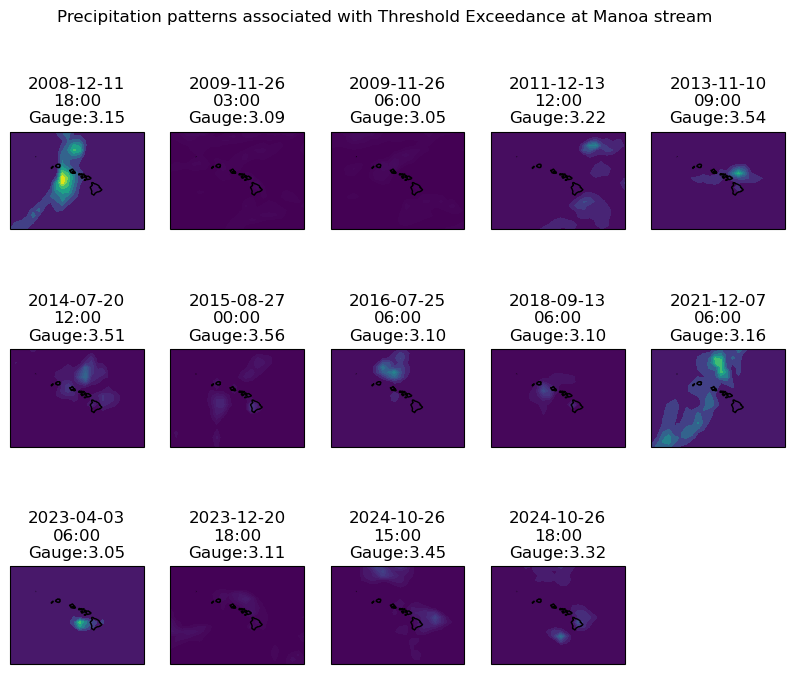

In [53]:
lons, lats = np.meshgrid(extreme_weathers.lon, extreme_weathers.lat)
fig, axs = plt.subplots(3,5, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(10,8))
vmin, vmax = extreme_weathers['tp'].min(), extreme_weathers['tp'].max()
fig.delaxes(axs[2,4])
for i, ax in enumerate(axs.flatten()[:-1]):
    individual_weather = extreme_weathers.isel(time=i) # xarray
    gauge = df_obs[df_obs.index == pd.Timestamp(individual_weather.time.values)]['measurement'].values[0] # pandas
    ax.contourf(lons, lats, individual_weather['tp'], vmin=vmin, vmax=vmax)
    ax.coastlines()
    ax.set_title(pd.Timestamp(individual_weather.time.values).strftime("%Y-%m-%d\n%H:%M") + f"\nGauge:{gauge:.2f}")

fig.suptitle('Precipitation patterns associated with Threshold Exceedance at Manoa stream')
pass

In [54]:
dry_months, wet_months = [5,6,7,8,9,10], [1,2,3,4,11,12]
wet_composite = extreme_weathers.sel(time=extreme_weathers['time'].dt.month.isin(wet_months))['tp'].mean(axis=0)
dry_composite = extreme_weathers.sel(time=extreme_weathers['time'].dt.month.isin(dry_months))['tp'].mean(axis=0)

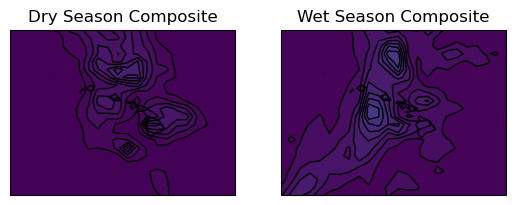

In [55]:
fig, axs = plt.subplots(1,2, subplot_kw=dict(projection=ccrs.PlateCarree()))
for ax, composite in zip(axs.flatten(), [dry_composite, wet_composite]):
    ax.contourf(lons, lats, composite, vmin=vmin, vmax=vmax)
    ax.coastlines()
    cs = ax.contour(lons, lats, composite, colors='k', linewidths=1, transform=ccrs.PlateCarree())
    # add contour labels
    # lb = plt.clabel(cs, fontsize=12, inline=False, fmt='%0.1f');
axs[0].set_title('Dry Season Composite')
axs[1].set_title('Wet Season Composite')
pass

In [56]:
seasonal_composite_ts = np.stack([dry_composite.to_numpy() if (t.month in dry_months) else wet_composite.to_numpy() for t in pd.to_datetime(concatenated.time)])

In [65]:
coors = corr_timeseries(concatenated['tp'].to_numpy(), seasonal_composite_ts)

In [66]:
df_stats = pd.DataFrame({'ts': concatenated.time, 'r': coors})
df_stats = pd.merge(df_obs, df_stats, left_index=True, right_on='ts')

In [67]:
df_stats['exceed'] = df_stats['measurement'] > 3

In [68]:
fpr, tpr, thresholds = roc_curve(df_stats.dropna()['exceed'], np.clip(df_stats.dropna()['r'], a_min=0, a_max=None))
roc_auc = auc(fpr, tpr)

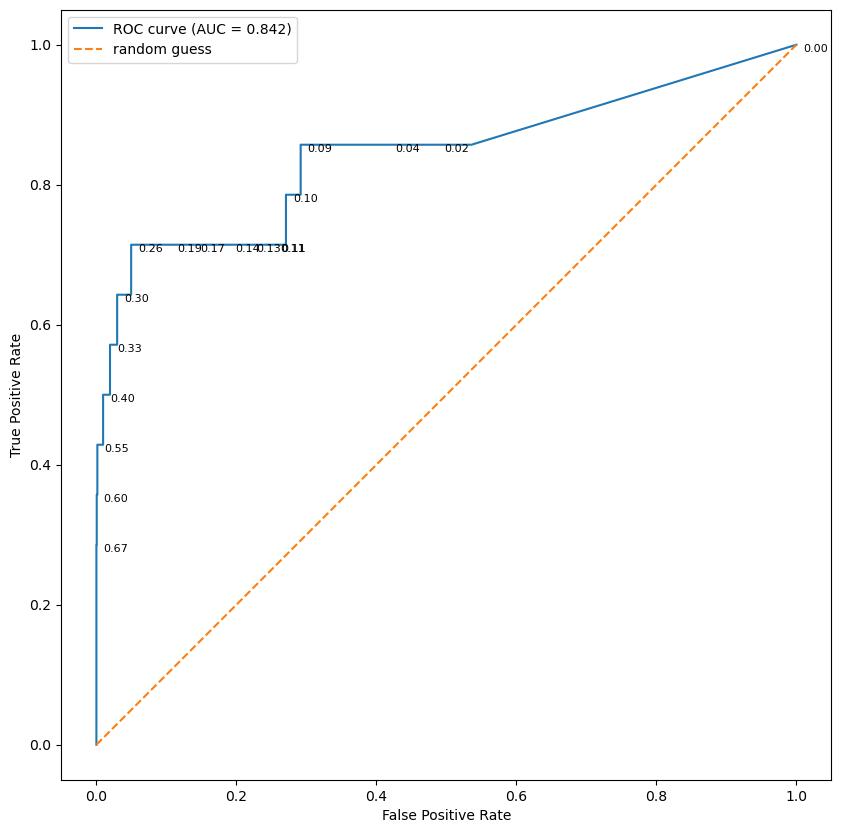

In [78]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.plot([0,1], [0,1], linestyle='--', label='random guess')
ax.legend()

# Annotate thresholds (skip first threshold; it's always > max score)
for fp, tp, thr in zip(fpr[2::2], tpr[2::2], thresholds[2::2]):
    ax.annotate(
        f"{thr:.2f}",
        xy=(fp, tp),
        textcoords="offset points",
        xytext=(5, -5),
        fontsize=8,
        color='black'
    )

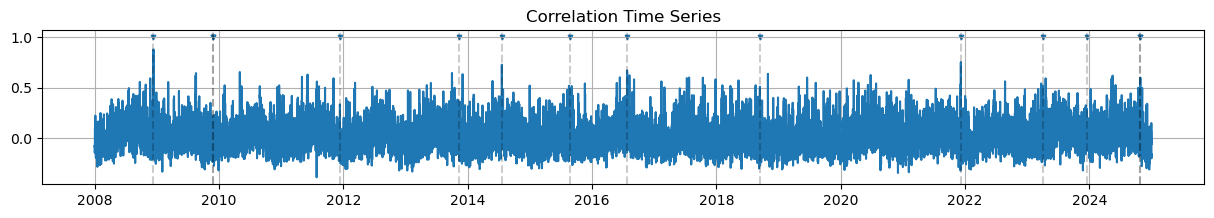

In [70]:
fig, ax = plt.subplots(1, figsize=(15,2))
ax.plot(df_stats['ts'], df_stats['r'])
ax.scatter(df_obs.query('measurement > 3').index, [1 for _ in range(len(df_obs.query('measurement > 3').index))], s=10, marker='v')
for i in df_obs.query('measurement > 3').index:
    ax.axvline(i, linestyle='--', c='k', alpha=0.2)
# ax.axhline(0.6, linestyle='--', c='orange')
ax.set_title('Correlation Time Series')
ax.grid()

In [90]:
(df_stats['r'] > 0.5).sum()/ df_stats.shape[0]

0.002758037565679544

# Run this on historical CMIP